# DRIVENDATA CHALLENGE: Prediction of 'Heart_Disease_present' probability represents whether or not a patient has heart disease 
##### (https://www.drivendata.org/competitions/54/machine-learning-with-a-heart)

In [1]:
#Import tools
from scipy.special import softmax
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as pl
import csv
import seaborn as sn
from sklearn.metrics import precision_score, recall_score,confusion_matrix
#from imblearn.over_sampling import KMeansSMOTE
from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score
from sklearn.ensemble import BaggingClassifier
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.pipeline import Pipeline,make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler,Normalizer,RobustScaler,OneHotEncoder
from sklearn.externals import joblib

In [2]:
#import datasets
#create data reader function
def data_reader():
    with open(filename) as f:
        fcsv = csv.DictReader(f)
        Data=[]
        for row in fcsv:
            Data.append(row)
    return Data

#Read train data
filename='train_values.csv'
Train_data=data_reader()

#create train data frame
Train_features_frame=pd.DataFrame(Train_data)
Train_features_frame.shape

(180, 14)

In [3]:
#Load train labels 
filename='train_labels.csv'
Train_labels=data_reader()

#create Train labels frame
Train_labels_frame=pd.DataFrame(Train_labels)

__NOTE: Test data features' number is 13 because label column is not attached__

In [4]:
#load test data
filename='test_values.csv'
Test_Data=data_reader()

Test_Data_frame=pd.DataFrame(Test_Data)
Test_Data_frame.set_index('patient_id',inplace=True)

Test_array=Test_Data_frame.values

#check data shape
Test_array.shape

(90, 13)

In [5]:
#full dataset
#combine the train features and labels
Full_train_data=pd.merge(Train_labels_frame,Train_features_frame, on='patient_id')

#set patient_id as index column
Full_train_data.set_index('patient_id',inplace=True)
columns=Full_train_data.columns
#view full data
Full_train_data.head(5)

,heart_disease_present,slope_of_peak_exercise_st_segment,thal,resting_blood_pressure,chest_pain_type,num_major_vessels,fasting_blood_sugar_gt_120_mg_per_dl,resting_ekg_results,serum_cholesterol_mg_per_dl,oldpeak_eq_st_depression,sex,age,max_heart_rate_achieved,exercise_induced_angina
patient_id,,,,,,,,,,,,,,
0z64un,0,1,normal,128,2,0,0,2,308,0.0,1,45,170,0
ryoo3j,0,2,normal,110,3,0,0,0,214,1.6,0,54,158,0
yt1s1x,1,1,normal,125,4,3,0,2,304,0.0,1,77,162,1
l2xjde,1,1,reversible_defect,152,4,0,0,0,223,0.0,1,40,181,0
oyt4ek,0,3,reversible_defect,178,1,0,0,2,270,4.2,1,59,145,0


In [6]:
columns

Index(['heart_disease_present', 'slope_of_peak_exercise_st_segment', 'thal',
       'resting_blood_pressure', 'chest_pain_type', 'num_major_vessels',
       'fasting_blood_sugar_gt_120_mg_per_dl', 'resting_ekg_results',
       'serum_cholesterol_mg_per_dl', 'oldpeak_eq_st_depression', 'sex', 'age',
       'max_heart_rate_achieved', 'exercise_induced_angina'],
      dtype='object')

In [7]:
# check full data shape
Full_train_data.shape

(180, 14)

In [8]:
#check missing Values
Full_train_data.isnull().sum()

heart_disease_present                   0
slope_of_peak_exercise_st_segment       0
thal                                    0
resting_blood_pressure                  0
chest_pain_type                         0
num_major_vessels                       0
fasting_blood_sugar_gt_120_mg_per_dl    0
resting_ekg_results                     0
serum_cholesterol_mg_per_dl             0
oldpeak_eq_st_depression                0
sex                                     0
age                                     0
max_heart_rate_achieved                 0
exercise_induced_angina                 0
dtype: int64

In [9]:
#check whether there are duplicate records
Full_train_data.duplicated().sum()

0

__'thal' is the only categorical data present having three unique values; other numeric values are not in the same scale__

In [10]:
#check statistics of the data
Full_train_data.describe()

,heart_disease_present,slope_of_peak_exercise_st_segment,thal,resting_blood_pressure,chest_pain_type,num_major_vessels,fasting_blood_sugar_gt_120_mg_per_dl,resting_ekg_results,serum_cholesterol_mg_per_dl,oldpeak_eq_st_depression,sex,age,max_heart_rate_achieved,exercise_induced_angina
count,180,180,180,180,180,180,180,180,180,180,180,180,180,180
unique,2,3,3,36,4,4,2,3,118,34,2,40,73,2
top,0,1,normal,130,4,0,0,2,239,0.0,1,54,162,0
freq,100,93,98,26,82,106,151,94,4,56,124,12,10,123


In [11]:
#Check full data sample class balance
(Full_train_data['heart_disease_present'].values==str(1)).sum(),(Full_train_data['heart_disease_present'].values==str(0)).sum()

(80, 100)

__It is apparent that the sampling is biased in favour of Class 0 against Class 1__

In [12]:
#separate full data to numeric and categorical and convert back numerical values encoded as string to numerical and then merge
#...numeric columns conversion class 
#define a custom transformer class
class to_numeric(BaseEstimator,TransformerMixin):
    def __init__(self,thal=True): # no *args or **kargs
        self.thal='thal' #thal column
    def fit(self,data,y=None):
        return self # nothing else to do
    def transform(self,data,y=None):
        cat_column=data.pop(self.thal).values
        num_columns=data.values
        #Convert from object type to numeric type
        num_columns1=pd.to_numeric(num_columns.flatten())
        num_columns=num_columns1.reshape(num_columns.shape)
        #encode categorical
        cat_encoder=OneHotEncoder(sparse=False)
        Encoded_cat=cat_encoder.fit_transform(cat_column[:,None])
        #merge the transformed data
        fulldata=np.hstack([num_columns,Encoded_cat])
        return fulldata,num_columns,Encoded_cat


transformer=to_numeric().fit(Full_train_data)      
fulldata,num_columns,Encoded_cat=transformer.transform(Full_train_data)

In [13]:
#let's view fulldata
fulldata_frame=pd.DataFrame(fulldata,columns=['heart_disease_present','slope_of_peak_exercise_st_segment',
                                              'resting_blood_pressure', 'chest_pain_type','num_major_vessels',
                                              'fasting_blood_sugar_gt_120_mg_per_dl', 'resting_ekg_results',
                                              'serum_cholesterol_mg_per_dl', 'oldpeak_eq_st_depression', 'sex', 'age',
                                              'max_heart_rate_achieved', 'exercise_induced_angina','enc1','enc2','enc3'])
fulldata_frame.head()

,heart_disease_present,slope_of_peak_exercise_st_segment,resting_blood_pressure,chest_pain_type,num_major_vessels,fasting_blood_sugar_gt_120_mg_per_dl,resting_ekg_results,serum_cholesterol_mg_per_dl,oldpeak_eq_st_depression,sex,age,max_heart_rate_achieved,exercise_induced_angina,enc1,enc2,enc3
0,0.0,1.0,128.0,2.0,0.0,0.0,2.0,308.0,0.0,1.0,45.0,170.0,0.0,0.0,1.0,0.0
1,0.0,2.0,110.0,3.0,0.0,0.0,0.0,214.0,1.6,0.0,54.0,158.0,0.0,0.0,1.0,0.0
2,1.0,1.0,125.0,4.0,3.0,0.0,2.0,304.0,0.0,1.0,77.0,162.0,1.0,0.0,1.0,0.0
3,1.0,1.0,152.0,4.0,0.0,0.0,0.0,223.0,0.0,1.0,40.0,181.0,0.0,0.0,0.0,1.0
4,0.0,3.0,178.0,1.0,0.0,0.0,2.0,270.0,4.2,1.0,59.0,145.0,0.0,0.0,0.0,1.0


In [14]:
#check the shapes of datasets
fulldata.shape,num_columns.shape,Encoded_cat.shape

((180, 16), (180, 13), (180, 3))

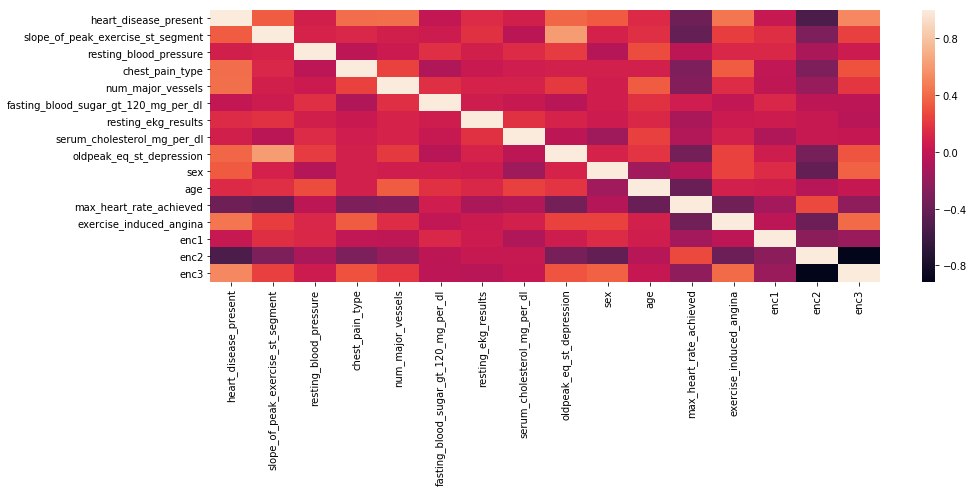

In [15]:
pl.figure(figsize=(15,5))
sn.heatmap(fulldata_frame.corr())
pl.show()

Based on the correlation heatmap above, there is a strong negative linear correlation between columns enc2 and enc3;likewise 

there is a strong positive correlation between 'slope_of_peak_exercise_st_segment' and 'oldpeak_eq_st_depression'.So we need  

to drop one for the other to reduce noise in the dataset to be fed into classifier algorithm.In this case I would drop 

'enc3' and 'slope_of_peak_exercise_st_segment' by including more pop codelines in our custom transformer__

In [16]:
#Let's view data statistics of numeric columns 
num_columns_frame=pd.DataFrame(num_columns,columns=['heart_disease_present','slope_of_peak_exercise_st_segment',
       'resting_blood_pressure', 'chest_pain_type', 'num_major_vessels',
       'fasting_blood_sugar_gt_120_mg_per_dl', 'resting_ekg_results',
       'serum_cholesterol_mg_per_dl', 'oldpeak_eq_st_depression', 'sex', 'age',
       'max_heart_rate_achieved', 'exercise_induced_angina'])
num_columns_frame.describe()

,heart_disease_present,slope_of_peak_exercise_st_segment,resting_blood_pressure,chest_pain_type,num_major_vessels,fasting_blood_sugar_gt_120_mg_per_dl,resting_ekg_results,serum_cholesterol_mg_per_dl,oldpeak_eq_st_depression,sex,age,max_heart_rate_achieved,exercise_induced_angina
count,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000
mean,0.444444,1.550000,131.311111,3.155556,0.694444,0.161111,1.050000,249.211111,1.010000,0.688889,54.811111,149.483333,0.316667
std,0.498290,0.618838,17.010443,0.938454,0.969347,0.368659,0.998742,52.717969,1.121357,0.464239,9.334737,22.063513,0.466474
min,0.000000,1.000000,94.000000,1.000000,0.000000,0.000000,0.000000,126.000000,0.000000,0.000000,29.000000,96.000000,0.000000
25%,0.000000,1.000000,120.000000,3.000000,0.000000,0.000000,0.000000,213.750000,0.000000,0.000000,48.000000,132.000000,0.000000
50%,0.000000,1.000000,130.000000,3.000000,0.000000,0.000000,2.000000,245.500000,0.800000,1.000000,55.000000,152.000000,0.000000
75%,1.000000,2.000000,140.000000,4.000000,1.000000,0.000000,2.000000,281.250000,1.600000,1.000000,62.000000,166.250000,1.000000
max,1.000000,3.000000,180.000000,4.000000,3.000000,1.000000,2.000000,564.000000,6.200000,1.000000,77.000000,202.000000,1.000000


In [17]:
#Let's drop redundant columns as revealed by correlation heatmap
fulldata_frame=fulldata_frame.drop(['slope_of_peak_exercise_st_segment','enc3'],axis=1)
fulldata_frame.head()

,heart_disease_present,resting_blood_pressure,chest_pain_type,num_major_vessels,fasting_blood_sugar_gt_120_mg_per_dl,resting_ekg_results,serum_cholesterol_mg_per_dl,oldpeak_eq_st_depression,sex,age,max_heart_rate_achieved,exercise_induced_angina,enc1,enc2
0,0.0,128.0,2.0,0.0,0.0,2.0,308.0,0.0,1.0,45.0,170.0,0.0,0.0,1.0
1,0.0,110.0,3.0,0.0,0.0,0.0,214.0,1.6,0.0,54.0,158.0,0.0,0.0,1.0
2,1.0,125.0,4.0,3.0,0.0,2.0,304.0,0.0,1.0,77.0,162.0,1.0,0.0,1.0
3,1.0,152.0,4.0,0.0,0.0,0.0,223.0,0.0,1.0,40.0,181.0,0.0,0.0,0.0
4,0.0,178.0,1.0,0.0,0.0,2.0,270.0,4.2,1.0,59.0,145.0,0.0,0.0,0.0


__The plot shows non-linearity in the pair plots of  some of non-categorical,non-binary numerical data.The diagonal axis shows data__ 

__distribution within each column. Some skewed to right and two of the features are approximately symmetric. This shows data__ 

__need to be rescaled to bring them to equal scale__

In [18]:
#Yah! It is time to divide the  train dataset into train set and validation set using stratified
#sampling because of class bias in dataset 
fulldata=fulldata_frame.values
Train_features,Val_features,Train_targets,Val_targets=train_test_split(fulldata[:,1:],fulldata[:,0],stratify=fulldata[:,0],test_size=0.2,random_state=1)

In [19]:
#View shape for consistency
Train_features.shape,Val_features.shape,Train_targets.shape,Val_targets.shape

((144, 13), (36, 13), (144,), (36,))

In [20]:
# Rescaling dataset so that they are on same scale
scaler=RobustScaler()
scaler.fit(Train_features)
scaled_train=scaler.transform(Train_features)
scaled_val=scaler.transform(Val_features)

### Now to model  training business


In [21]:
#Let's define pipeline for our processes; Since requirement for training cost function , accroding to DRIVENDATA's 
#...Heart_Disease_prediction competition requirements, is log loss function, I decided to 
#...use Logistic regression algorithm as estimators in ensembles. 
lgr=LogisticRegression(C=0.1,solver='lbfgs',class_weight='balanced')#'liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'
model=lgr.fit(scaled_train,Train_targets)
train_acc=model.score(scaled_train,Train_targets)
pred_train=model.predict(scaled_train)
#validate
y_pr=model.predict_proba(scaled_val)
pred=model.predict(scaled_val)

In [22]:
#Train performances:accuracy, recall and prediction
np.round(train_acc,2),recall_score(Train_targets,pred_train),precision_score(Train_targets,pred_train)

(0.86, 0.828125, 0.8548387096774194)

In [23]:
#validation performances
pd.DataFrame({'pred_proba':np.vstack(y_pr)[:,1],'target':Val_targets.astype(np.int),'pred':pred.astype(np.int)}).head(25)


,pred_proba,target,pred
0,0.398364,0,0
1,0.661722,1,1
2,0.398111,0,0
3,0.473682,0,0
4,0.811010,1,1
5,0.232387,1,0
6,0.703261,1,1
7,0.395587,1,0
8,0.182132,0,0
9,0.669096,0,1


In [24]:
#validation performances metrics:accuracy, recall and prediction
np.round(model.score(scaled_val,Val_targets),2),recall_score(Val_targets,pred),precision_score(Val_targets,pred)

(0.78, 0.75, 0.75)

In [25]:
#Model parameter Tuning using cross-validation
C = np.linspace(20, 100, 20)
# Create hyperparameter options
hyperparameters = dict(C=C)

# Create grid search
gridsearch = GridSearchCV(lgr,hyperparameters,cv=10,n_jobs=-1,verbose=0)

#Conduct nested cross-validation and output the average score
acc=cross_val_score(gridsearch,scaled_train,Train_targets).mean()

#Retrain best model
final_model=gridsearch.fit(np.vstack([scaled_train,scaled_val]),np.hstack([Train_targets,Val_targets]))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of t

In [26]:
#Best_value of C parameter and accuracy
final_model.best_estimator_.get_params()['C' ],np.round(acc,2)

(20.0, 0.83)

In [27]:
#save final model
joblib.dump(final_model,'DRIVENDATA_MDL')

['DRIVENDATA_MDL']

In [28]:
#Test final model with unseen test dataset
cols=Test_Data_frame.index

#Preprocess Data
testdata,_,_=transformer.transform(Test_Data_frame)

#Let's reemove redundant columns from test data
testdataframe=pd.DataFrame(testdata, columns=['slope_of_peak_exercise_st_segment',
                                              'resting_blood_pressure', 'chest_pain_type','num_major_vessels',
                                              'fasting_blood_sugar_gt_120_mg_per_dl', 'resting_ekg_results',
                                              'serum_cholesterol_mg_per_dl', 'oldpeak_eq_st_depression', 'sex', 'age',
                                              'max_heart_rate_achieved', 'exercise_induced_angina','enc1','enc2','enc3']).drop(['slope_of_peak_exercise_st_segment','enc3'],axis=1)
    
#Rescale data using previously defined scaler
scaled_test=scaler.transform(testdataframe.values)

In [29]:
scaled_test.shape

(90, 13)

In [30]:
test_pred_proba=final_model.predict_proba(scaled_test)
pred_test=final_model.predict(scaled_test)

In [31]:
results=pd.DataFrame({'patient_id':cols,'test_pred':(pred_test).astype(np.int),'heart_disease_present':test_pred_proba[:,1]})

In [32]:
results.head(10)

,patient_id,test_pred,heart_disease_present
0,olalu7,0,0.270044
1,z9n6mx,0,0.069838
2,5k4413,1,0.959534
3,mrg7q5,0,0.062194
4,uki4do,1,0.951948
5,kev1sk,0,0.022764
6,9n6let,0,0.045908
7,jxmtyg,1,0.980916
8,51s2ff,0,0.203763
9,wi9mcs,0,0.195918


In [33]:
final_results=results.iloc[:,[0,2]]

In [34]:
final_results.to_csv('OLALEKAN_SUBMISSION_HEART_DISEASE_PREDICTION.csv')

In [35]:
final_results

,patient_id,heart_disease_present
0,olalu7,0.270044
1,z9n6mx,0.069838
2,5k4413,0.959534
3,mrg7q5,0.062194
4,uki4do,0.951948
5,kev1sk,0.022764
6,9n6let,0.045908
7,jxmtyg,0.980916
8,51s2ff,0.203763
9,wi9mcs,0.195918
